In [1]:
#packages and data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import mat73 #for large dictionary type files - cell structures
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras import regularizers

data_dict = mat73.loadmat('Data/All_data_images.mat')
mdata = data_dict['Dataset'] 
labels = []
images = []
sizex = mdata[0][0][1].shape[0]
sizey = mdata[0][0][1].shape[1]
for idx, particle in enumerate(mdata):
    for n, frame in enumerate(particle):
        if frame[1].shape != (sizex,sizey): #remove images with off dimensions because they are too close to edge
            continue
        labels.append(frame[0])
        images.append(frame[1]/255) 
        
all_labels = np.array(labels)#, dtype='object')
all_images = np.array(images)#, dtype='object')



In [2]:
#train-valid-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(all_images,all_labels, random_state=42, test_size = 0.2 )
X_train2, X_validation, Y_train2, Y_validation = train_test_split(X_train,Y_train, random_state=42, test_size = 0.1 )
#save 10% of the xtrain initial set for validation

In [3]:
#getting data in right format 
K.clear_session()
img_rows, img_cols = sizey, sizex
#inputshape = X.shape[1]

if K.image_data_format() == 'channels_first':
    X_train2 = X_train2.reshape(X_train2.shape[0], 1, img_rows, img_cols)
    X_validation = X_validation.reshape(X_validation.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: #reshape for format required of the model fitting
    X_train2 = X_train2.reshape(X_train2.shape[0], img_rows, img_cols, 1)
    X_validation = X_validation.reshape(X_validation.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train2 = X_train2.astype('float32')
X_validation = X_validation.astype('float32')

print('X_train shape:', X_train2.shape)
print(X_train2.shape[0], 'train samples')
print(X_validation.shape[0], 'validation samples')

X_train shape: (28180, 87, 87, 1)
28180 train samples
3132 validation samples


In [4]:
#the optimised simple model for the problem
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, strides=2, input_shape=[sizex,sizey,1], padding="same",use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(128,3, padding="same"), 
    keras.layers.Activation("relu"),
    keras.layers.Flatten(), 
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="linear", activity_regularizer=regularizers.l2(1e-5)) #try regularising output 
])
#using the l2 regularisation is less punishing than dropout (0.5) - therefore since not overfitting, better results
#early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.01, patience=5,
                                           restore_best_weights=True)
csv_logger = CSVLogger('training_no_dropout_l2regularise_2convactivate_1conv_DN.log', separator=',', append=False) 
opt = tf.keras.optimizers.Adam(epsilon=1e-3) #1, 0.1 for imagenet problems
model.compile(loss='mean_absolute_error',#mean absolute works better due to outliers?#'mean_squared_error',#is the error of estimation normally distributed or laplacian with outliers? anyway MS is typicall better 'mean_absolute_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer=opt,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        576       
                                                                 
 activation (Activation)     (None, 44, 44, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 activation_1 (Activation)   (None, 44, 44, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 247808)            0         
                                                                 
 dense (Dense)               (None, 64)                1

2022-01-25 22:41:15.353325: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#model fitting
batch_size = 100
epochs =500

model.fit(X_train2, Y_train2,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[callback, csv_logger],
          verbose=1,
          validation_data=(X_validation, Y_validation))
score = model.evaluate(X_test, Y_test, verbose=0)
score

Epoch 1/500
282/282 [==============================] - 245s 865ms/step - loss: 3.5052 - root_mean_squared_error: 4.7907 - val_loss: 1.0443 - val_root_mean_squared_error: 1.4402
Epoch 2/500
282/282 [==============================] - 245s 867ms/step - loss: 0.8944 - root_mean_squared_error: 1.2167 - val_loss: 1.1836 - val_root_mean_squared_error: 1.5029
Epoch 3/500
282/282 [==============================] - 249s 882ms/step - loss: 0.8830 - root_mean_squared_error: 1.2715 - val_loss: 3.0893 - val_root_mean_squared_error: 3.8080
Epoch 4/500
282/282 [==============================] - 251s 890ms/step - loss: 0.8603 - root_mean_squared_error: 1.2959 - val_loss: 0.6045 - val_root_mean_squared_error: 0.7762
Epoch 5/500
282/282 [==============================] - 256s 908ms/step - loss: 0.6400 - root_mean_squared_error: 0.8498 - val_loss: 0.6579 - val_root_mean_squared_error: 0.8471
Epoch 6/500
282/282 [==============================] - 255s 905ms/step - loss: 0.5819 - root_mean_squared_error: 0.

[0.5112735629081726, 0.6497389078140259]

In [6]:
model.save("500epochs_earlystop_adam_2convlayers_1conv_noactivate_1dense_nodropout_l2reg.h5")

In [4]:
from tensorflow import keras
model = keras.models.load_model('500epochs_earlystop_adam_2convlayers_1dense_nodropout_l2reg_secondfit.h5')

2022-02-06 17:50:30.543709: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Residuals without removing outliers (labelling): 0.6220002942479094 
 Residuals with outliers removed: 0.6191357337469258
num outliers: 3, % outliers: 0.0003832396525293817


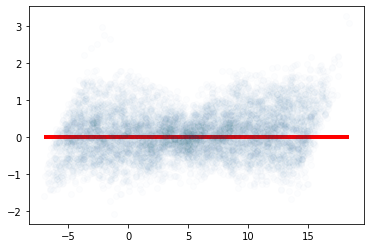

In [5]:
#model prediction
from sklearn.metrics import mean_squared_error

def Tukey_IQR(array, low=25, high=75, outlier_var = 1.5):
    import numpy as np
    LQR = np.percentile(array, low)
    UQR = np.percentile(array, high)
    IQR = UQR-LQR
    return LQR - outlier_var*IQR, UQR + outlier_var*IQR

def Tukey_outlier_detection(array, low=25, high=75, outlier_var=1.5):
    L, H = Tukey_IQR(array, low, high, outlier_var)
    return np.where((array < L) | (array > H))[0]


predictions = model.predict(X_test)

residuals = Y_test.ravel()-predictions.ravel()

outliers = Tukey_outlier_detection(residuals.ravel(), outlier_var=3) #due to poor labelling
Y_test_no_outliers = np.delete(Y_test.ravel(),(outliers))
residuals_no_outliers = np.delete(residuals,(outliers))
final_preds_no_outliers = np.delete(predictions.ravel(),(outliers))
%matplotlib inline
plt.plot(Y_test,residuals,'o', alpha=0.01)
# plt.plot(Y_test_no_outliers,residuals_no_outliers,'o', alpha=0.01)
plt.hlines(0,min(Y_test),max(Y_test),color='r',linewidth=4)
print(f"Residuals without removing outliers (labelling): {np.sqrt(mean_squared_error(Y_test.ravel(), predictions.ravel()))} \n Residuals with outliers removed: {np.sqrt(mean_squared_error(Y_test_no_outliers, final_preds_no_outliers))}")
print(f"num outliers: {len(outliers)}, % outliers: {len(outliers)/len(Y_test)}")

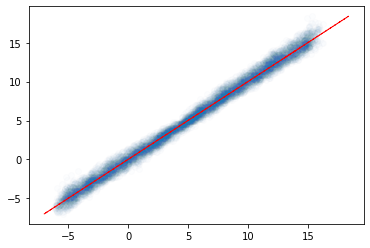

In [6]:
plt.plot(predictions,Y_test,'o', alpha=0.01)
plt.plot(Y_test,Y_test,'r--', linewidth=1)

In [36]:
#extracting the logged data
import pandas as pd
log_data = pd.read_csv('training_no_droppout_l2regularise_1.log', sep=',', engine='python')
log_data_2 = pd.read_csv('training_no_droppout_l2regularise_2.log', sep=',', engine='python')

In [44]:
log_data_all = pd.concat([log_data,log_data_2])

,epoch,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0,4.627732,5.842147,3.224861,4.892642
1,1,1.475639,2.250533,1.105236,1.485677
2,2,0.793521,1.085514,0.694892,0.956984
3,3,0.680800,0.916927,0.851817,1.105489
4,4,0.662064,0.876871,0.602668,0.783129
5,5,0.635526,0.837762,0.643458,0.804933
6,6,0.582264,0.754550,0.575942,0.724264
7,7,0.610263,0.818153,0.555422,0.699929
8,8,0.556240,0.710572,0.636386,0.793918
9,9,0.556791,0.715925,0.663272,0.849802


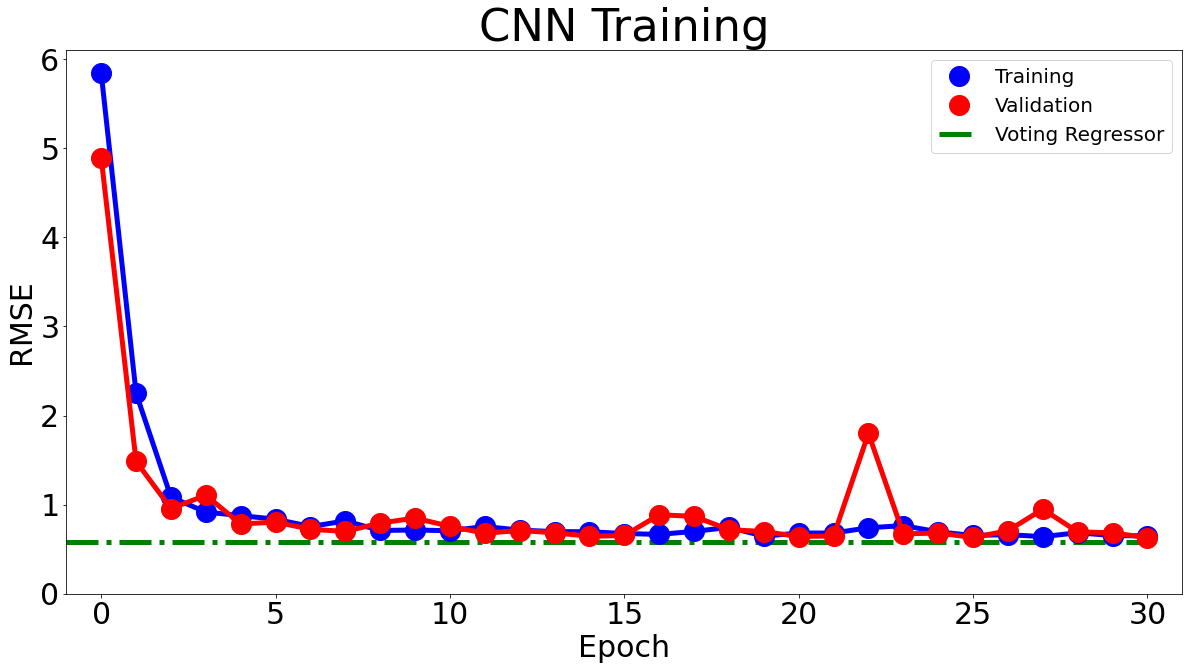

In [71]:
# train_error = [4.8644,2.193, 1.8219,1.746,1.7306,1.6959,1.6896,
#                     1.6812,1.6838,1.6402,1.6672,1.6318,1.6222]
# val_error = [3.1601, 1.3653, 0.8875, 1.2681, 0.7944, 1.3068, 0.7489, 0.733, 
#             1.217, 0.9098, 1.1707, 0.8784, 0.8254]

plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(log_data_all["root_mean_squared_error"].values, 'bo', markersize=20, label="Training")
plt.plot(log_data_all["root_mean_squared_error"].values, 'b', linewidth=5)
plt.plot(log_data_all["val_root_mean_squared_error"].values, 'ro', markersize=20, label="Validation")
plt.plot(log_data_all["val_root_mean_squared_error"].values, 'r', linewidth=5)
plt.hlines(0.577, -1, 30, 'g', '-.',  linewidth=5, label="Voting Regressor")
plt.ylabel("RMSE", fontsize=30)
plt.xlabel("Epoch", fontsize=30)
plt.ylim([0,6.1])
plt.xlim([-1,31])
plt.title("CNN Training", fontsize=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)